<a href="https://www.kaggle.com/code/hermengardo/ps6e2-eda-ensembling?scriptVersionId=298266210" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Imports</h1>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
import re
import seaborn as sns
import warnings
import optuna
import logging
import tensorflow as tf

from scipy.stats import rankdata
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.models import Sequential
from catboost import CatBoostClassifier
from hillclimbers import climb_hill, partial
from lightgbm import LGBMClassifier
from matplotlib.patches import Patch
from rich.console import Console
from sklearn.cluster import KMeans
from itertools import combinations, permutations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.base import clone
from tqdm import tqdm
from dataclasses import dataclass, field
from typing import List, Dict, Callable
from random import randint

warnings.filterwarnings("ignore")

2026-02-17 18:15:54.056340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771352154.254399      30 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771352154.314910      30 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771352154.834132      30 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771352154.834184      30 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771352154.834187      30 computation_placer.cc:177] computation placer alr

In [2]:
rc = {
    "axes.facecolor": "#fff",
    "axes.edgecolor": "#0e0e0e",
    "figure.facecolor": "#fff",
    "grid.color": "#0e0e0e",
    "axes.grid": True,
    
    "grid.linestyle":"--",
    "axes.labelcolor": "#0e0e0e",
    "xtick.color": "#0e0e0e",
    "ytick.color": "#0e0e0e",
    "legend.labelcolor": "#0e0e0e",
    "legend.edgecolor": "#fff",
    "patch.edgecolor": "#0B90A7",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "font.size": 18,
    "font.family": "serif",
    "font.weight": "bold",
    "grid.alpha": 0.1,
}

props = {
    'boxprops': {'edgecolor': '#0e0e0e', 'alpha': 1},
    'medianprops': {'color': '#0e0e0e', 'linestyle': '-', 'linewidth': 0.7},
    'whiskerprops': {'color': '#0e0e0e', 'linestyle': '--', 'linewidth': 0.7},
    'capprops': {'color': '#0e0e0e', 'linewidth': 0.7},
    'flierprops': {'marker': 'o', 'markersize': 4, 'markerfacecolor': 'none', 'markeredgecolor': '#0e0e0e', 'markerfacecolor': '#fffdf7', 'linewidth': 0.7}
}

sns.set(rc=rc)

sns.despine()

<Figure size 640x480 with 0 Axes>

In [3]:
@dataclass
class Settings:
    target: str
    identifier: str | None
    shuffle: bool
    splits: int
    seed:int
    seeds: List[int]|None = field(default_factory=list)
    
    def __repr__(self) -> str:
        return f""" 
        {"="*12} Settings {"="*12}
        ==> Target: {self.target}
        ==> Identifier: {self.identifier}
        ==> Shuffle: {self.shuffle}
        ==> Number of splits: {self.splits}
        ==> Seed: {self.seed}
        ==> Seeds: {" | ".join(map(str, self.seeds))}
        {"="*34}
        """

CFG = Settings(
    target="Heart Disease",
    identifier="id",
    shuffle=True,
    splits=10,
    seed=12
)

CFG

 
        ============ Settings ============
        ==> Target: Heart Disease
        ==> Identifier: id
        ==> Shuffle: True
        ==> Number of splits: 10
        ==> Seed: 12
        ==> Seeds: 
        

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Loading</h1>
</div>

In [4]:
def read_data(directory:str) -> tuple:
    """
        Read CSV files from a directory and return train, test, and submission DataFrames.
    """
    data = {}
    for filename in os.listdir(directory):
        key = re.search("(.*).csv", filename).group(1)
        data[key] = pd.read_csv(
            os.path.join(
                directory, 
                filename
            )
        )
    
    train = data["train"]
    test  = data["test"]
    sub   = data["sample_submission"]
        
    return train, test, sub

In [5]:
train, test, sub = read_data("/kaggle/input/playground-series-s6e2")

train["Heart Disease"] = train["Heart Disease"].replace({
    "Presence":1,
    "Absence":0
}).astype(int).copy()

train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Exploratory Data Analysis">
    ✨ EDA
  </h1>
</div>
     
* **Main takeaways:**
  1. Heart Disease is **highly correlated** with Chest pain type and Thalium.
  2. Chest pain of **type 4** is correlated with the presence of Heart Disease.
  3. Chest pain of **types 1, 2, and 3** is correlated with the absence of Heart Disease.
  4. Highly **imbalanced data** on FBS over 120 (92% of the data comes from the same category)
  6. **Older people** are more likely to have Heart Disease (no surprises, I guess)

In [6]:
def ridgeline(df, x, row, title, xlabel, pallete="viridis"):
    """
    Given a DataFrame, a target column, and a categorical variable used for
    aggregation, this function produces a kde ridgeplot.
    
    See:
    https://seaborn.pydata.org/examples/kde_ridgeplot
    """
    sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0), "axes.grid": False})
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=8, height=2, palette=pallete)
    g.map(sns.kdeplot, x, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=2.5)
    g.map(sns.kdeplot, x, clip_on=False, color="black", lw=2.5, bw_adjust=.5)
    g.refline(y=0, linewidth=2.5, linestyle="-", color="black", clip_on=False)

    def label(x, color, label):
        plt.gca().text(0, .2, label, fontweight="bold",
                       color=color, ha="left",
                       va="center", transform=plt.gca().transAxes)

    g.map(label, x)
    g.figure.suptitle(title, fontsize=16, fontweight="bold", y=1.05)
    g.set_xlabels(xlabel)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

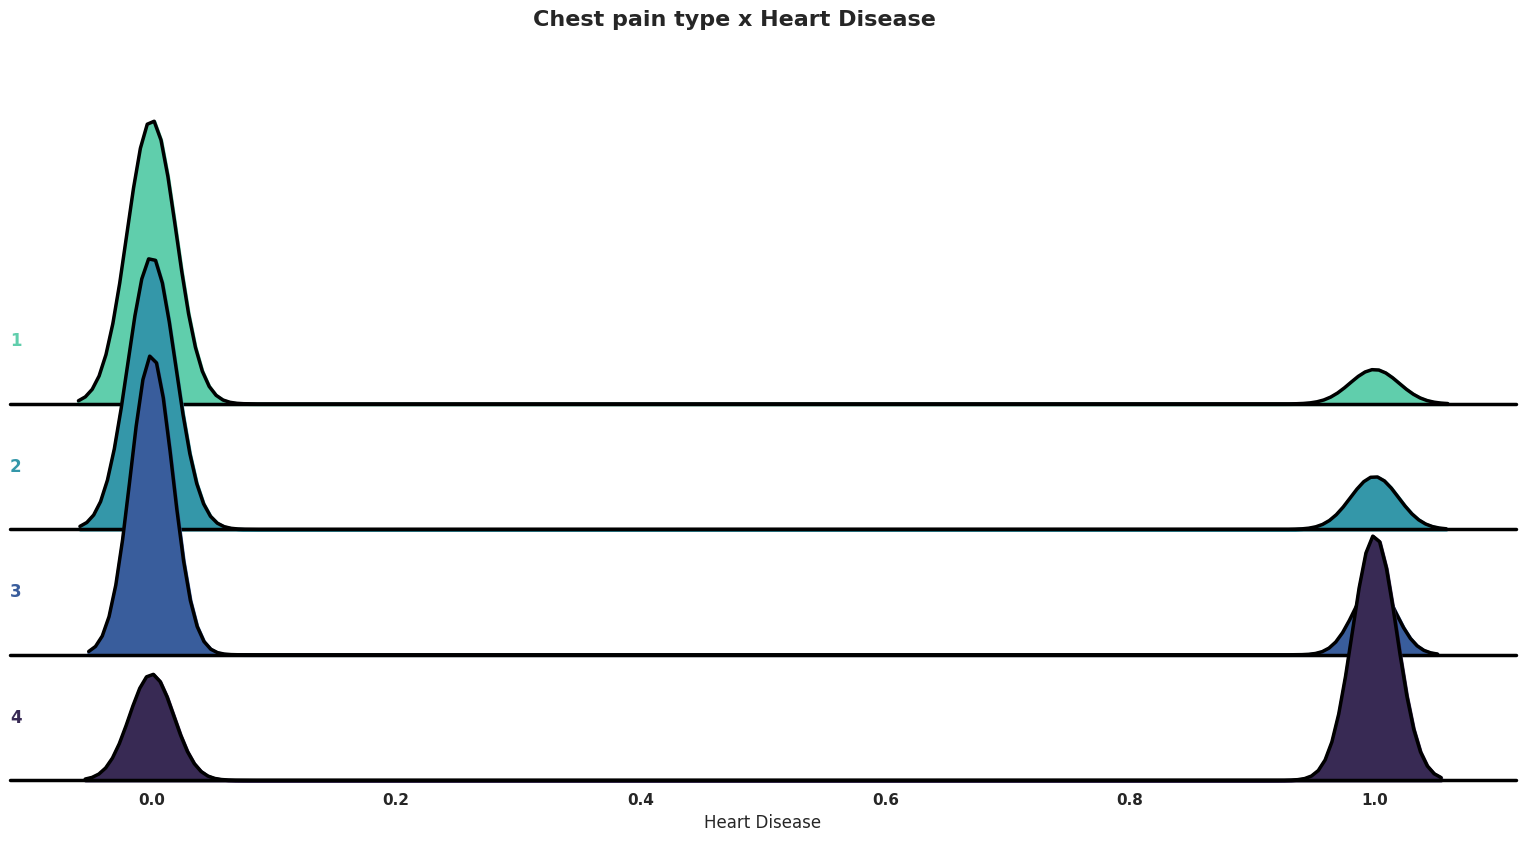

In [7]:
ridgeline(
    train,
    x="Heart Disease",
    row="Chest pain type",
    title=f"Chest pain type x Heart Disease",
    xlabel="Heart Disease",
    pallete="mako_r"
)

sns.set(rc=rc)

In [8]:
def plot_box(df, target, cols=3, colors=['#0B90A7','#E63946', '#E9C46A'], figsize=(15, 8), y_title=None, title=None, props=props):
    columns = df.select_dtypes('int').columns
    rows = np.ceil(len(columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    yt_labels = []
    for i, x in enumerate(columns):
        if x == target:
            continue
            
        current_ax = ax[i // cols, i % cols]
        sns.boxplot(data=df, y=target, ax=current_ax, x=x, orient='h', palette=colors, **props)
        current_ax.set_xlabel(x)
        
        if y_title and i % cols == 0:
            if len(yt_labels) == 0:
                yt_labels = [label.get_text() for label in current_ax.get_yticklabels()]
            current_ax.set_ylabel(y_title)
            current_ax.set_yticklabels(yt_labels)
        else:
            current_ax.set_ylabel('')
            current_ax.set_yticklabels('')
            
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(columns) - 1 < (rows * cols):
        for i in range(len(columns) - 1, rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Absence'),
        Patch(facecolor=colors[1], edgecolor='black', label='Presence')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .94),
        frameon=False
    )
    
    fig.tight_layout()
    plt.show()

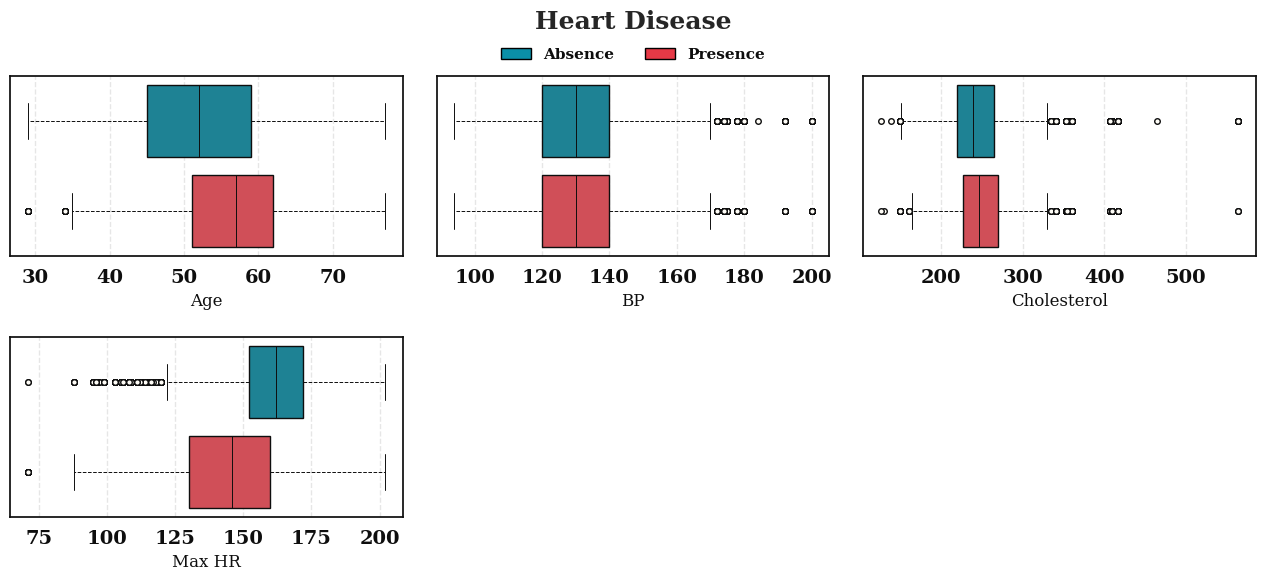

In [9]:
cat = ["id", "FBS over 120", 
       "Sex", "Chest pain type", 
       "EKG results", "Exercise angina", 
       "Slope of ST", "Number of vessels fluro", 
       "Thallium"]

plot_box(
    train.drop(cat, axis=1), 
    'Heart Disease', 
    figsize=(13, 6), 
    title='Heart Disease'
)

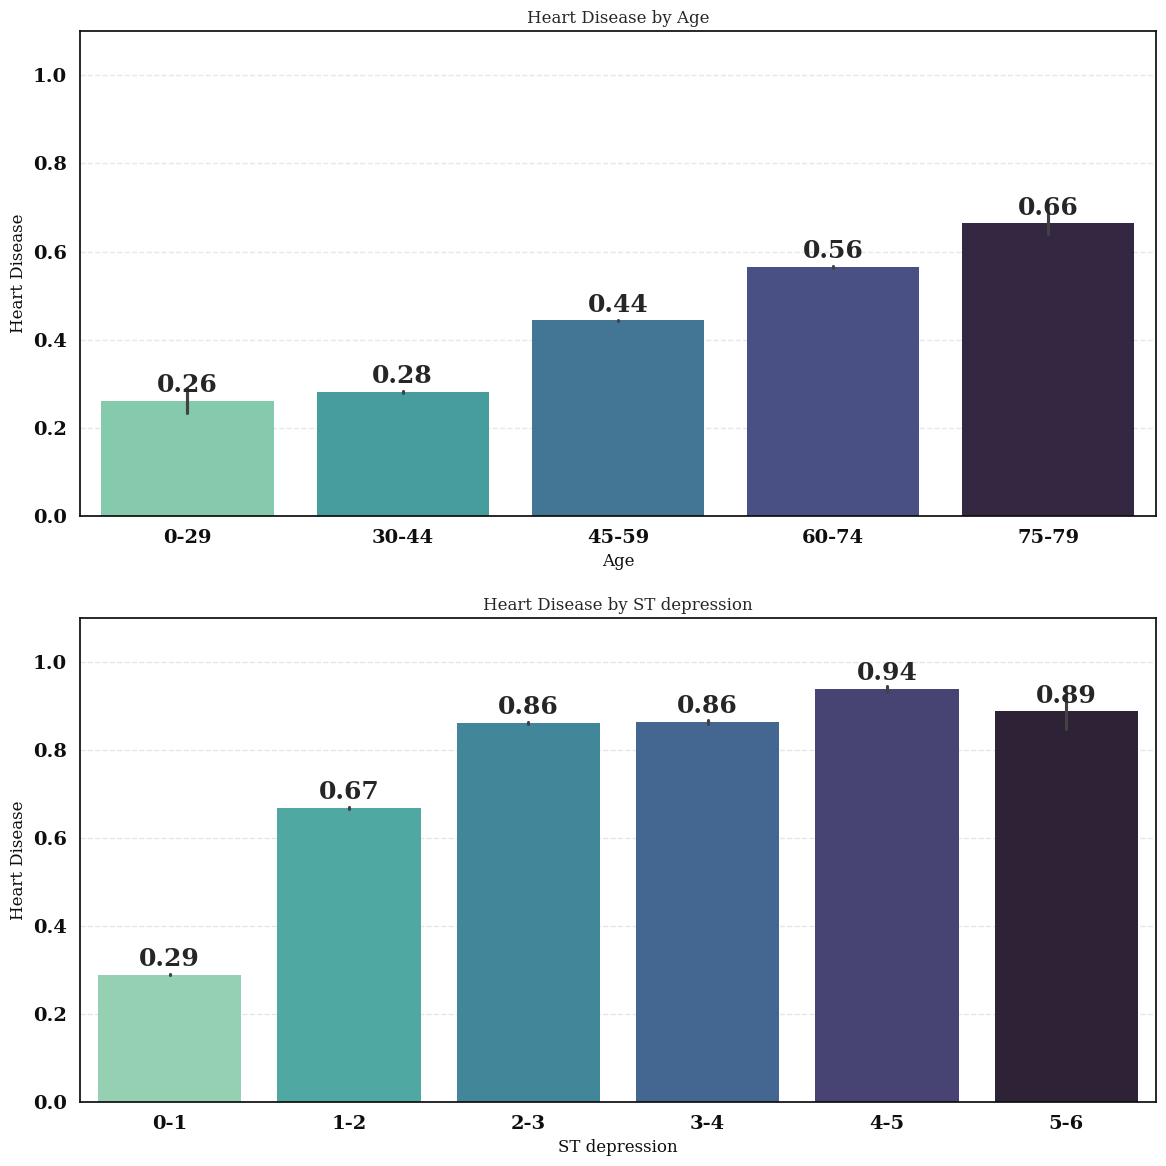

In [10]:
tmp = train.copy()

tmp['Age'] = pd.cut(tmp.Age, 
                    bins=[0, 30, 45, 60, 75, 80], 
                    labels=['0-29','30-44','45-59','60-74','75-79'], 
                    right=False)

tmp["ST depression"] = pd.cut(tmp["ST depression"], 
                    bins=[0, 1, 2, 3, 4, 5, 6], 
                    labels=['0-1','1-2','2-3','3-4','4-5', '5-6'], 
                    right=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(
    data=tmp,
    x="Age",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none",
    ax=axes[0]
)

for i, v in enumerate(tmp.groupby('Age')['Heart Disease'].mean()):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center')

axes[0].set_title("Heart Disease by Age")
axes[0].set_ylim(0, 1.1)

sns.barplot(
    data=tmp,
    x="ST depression",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none",
    ax=axes[1]
)

for i, v in enumerate(tmp.groupby('ST depression')['Heart Disease'].mean()):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center')

axes[1].set_title("Heart Disease by ST depression")
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

tmp = None

* **Main takeaways:**
    1. **Distributions look similar for both datasets**
    2. **Class 1 is almost nonexistent on EKG results**
    3. **Classes 2 and 3 of EKG results have similar proportions ~50/50**
    4. **ST depression with a heavy right tail, mostly because of the zeroes**

In [11]:
def plot_kde(df1:pd.DataFrame, 
             df2:pd.DataFrame, 
             cols:int = 3, 
             fill:bool = True, 
             figsize:tuple = (15, 12),
             colors:list = ["#0B90A7", "#E63946"], 
             title:str = None) -> None:

    df1 = df1.copy()
    df2 = df2.copy()

    df1.drop([CFG.identifier, CFG.target], axis=1, inplace=True)
    df2.drop([CFG.identifier], axis=1, inplace=True)
    
    numeric_columns = df1.select_dtypes(include='number').columns
    rows = np.ceil(len(numeric_columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for i, x in enumerate(numeric_columns):
        current_ax = ax[i // cols, i % cols]
        sns.kdeplot(x=x,
                    color=colors[0],
                    fill=fill,
                    data=df1,
                    label='Train',
                    ax=current_ax)
        sns.kdeplot(x=x,
                    color=colors[1],
                    fill=fill,
                    data=df2,
                    label='Test',
                    ax=current_ax)
        current_ax.set_xlabel(x)
    
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(numeric_columns) < (rows * cols):
        for i in range(len(numeric_columns), rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Train'),
        Patch(facecolor=colors[1], edgecolor='black', label='Test')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .96),
        frameon=False
    )

    fig.tight_layout()
    plt.show()

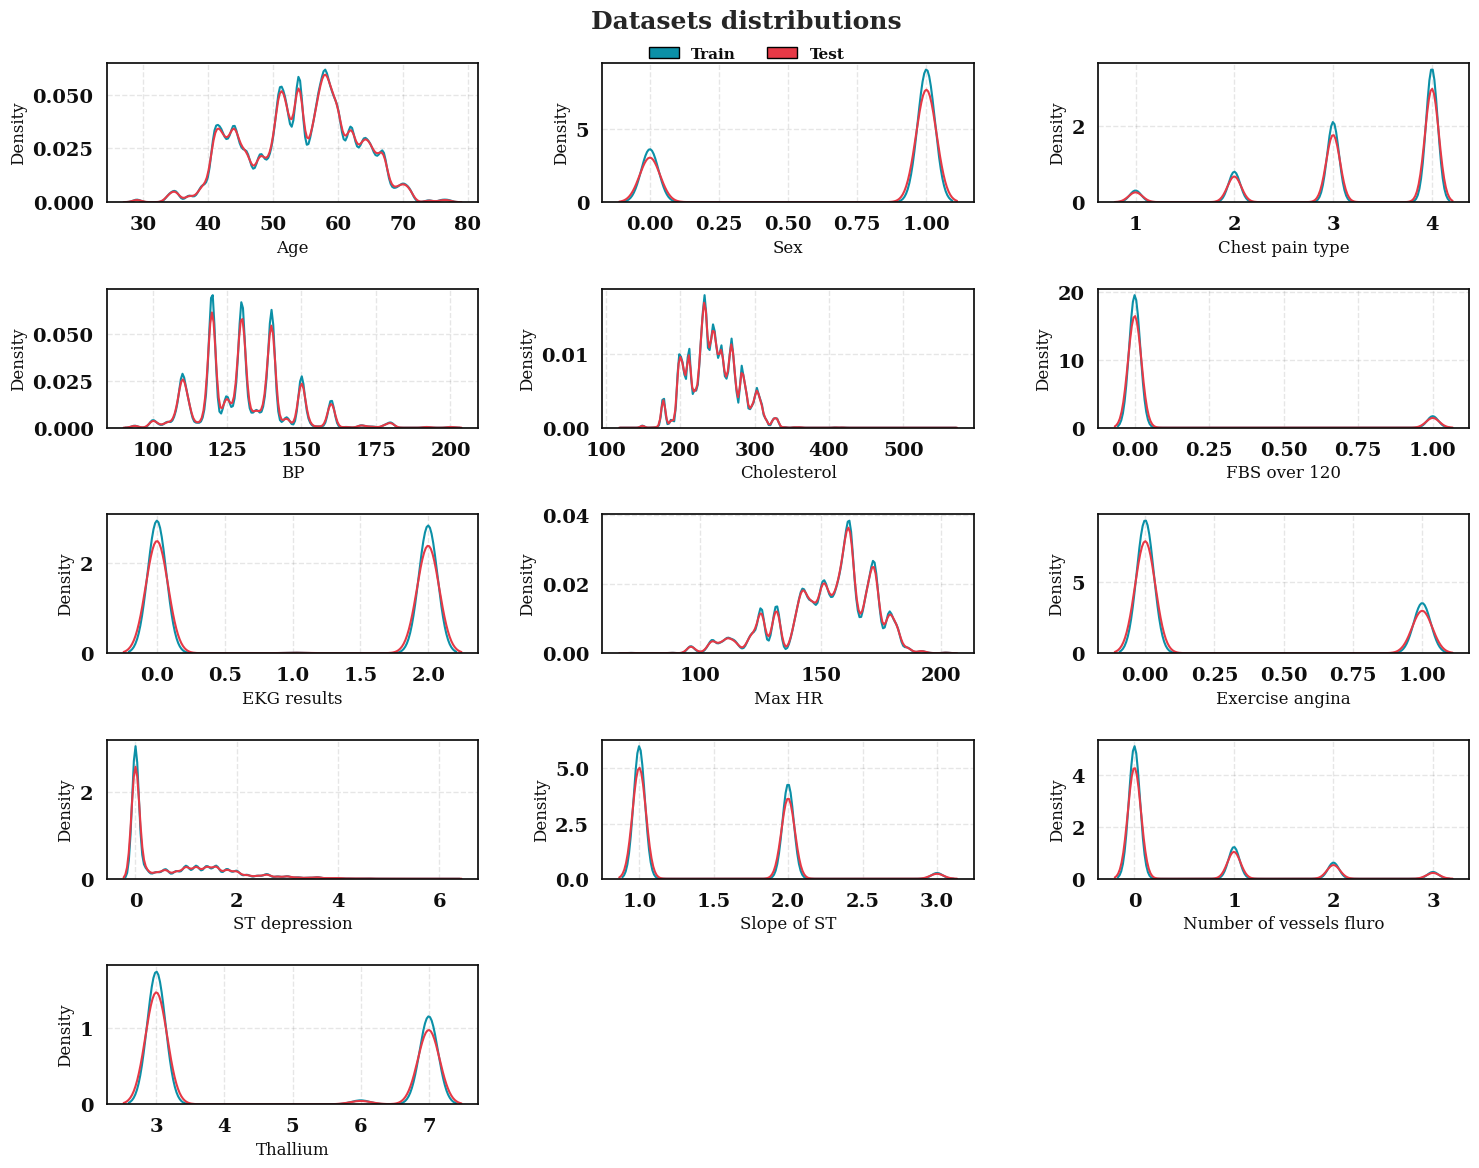

In [12]:
plot_kde(train, test, fill=False, title='Datasets distributions')

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Feature Engineering">
    ✨ Feature Engineering
  </h1>
</div>

In [13]:
X, y = train.drop(["Heart Disease", "id"], axis=1), train["Heart Disease"]

X_test = test.drop('id', axis=1)

km = KMeans(n_clusters=2, n_init='auto')
X['Cluster'] = km.fit_predict(X)

train.loc[:, 'Cluster'] = X['Cluster']
test.loc[:, 'Cluster'] = km.predict(X_test)

In [14]:
train.drop(["id"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

In [15]:
X, y = train.drop(["Heart Disease"], axis=1), train["Heart Disease"]
X_test = test

In [16]:
def feature_selection(X, y, clf, cv, seed=42, tolerance=0.0001):

    X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    remaining = list(X_dev.columns)
    selected = []
    best_score = 0.0

    console = Console()

    while remaining:
        scores = []

        for feature in remaining:
            current = selected + [feature]
            roc = []

            for train_idx, val_idx in cv.split(X_dev, y_dev):
                X_train = X_dev[current].iloc[train_idx]
                X_val = X_dev[current].iloc[val_idx]
                y_train = y_dev.iloc[train_idx]
                y_val = y_dev.iloc[val_idx]

                model = clone(clf)
                model.fit(X_train, y_train)

                probs = model.predict_proba(X_val)[:, 1]
                roc.append(roc_auc_score(y_val, probs))

            scores.append((feature, np.mean(roc)))

        best_feature, best_feature_score = max(scores, key=lambda x: x[1])

        if best_feature_score > best_score + tolerance:
            selected.append(best_feature)
            remaining.remove(best_feature)
            best_score = best_feature_score
            console.print(f"Keeping {best_feature} | {best_feature_score:.4f}", style="bold green")
        else:
            break

    final_model = clone(clf)
    final_model.fit(X_dev[selected], y_dev)

    test_probs = final_model.predict_proba(X_test[selected])[:, 1]
    final_test_score = roc_auc_score(y_test, test_probs)

    console.print(f"\nFinal Test Score: {final_test_score:.4f}")

    return selected

In [17]:
skf = StratifiedKFold(n_splits=3, shuffle=CFG.shuffle, random_state=CFG.seed)

clf = LGBMClassifier(
        objective="binary",
        metric="auc",
        verbosity=-1,
        random_state=CFG.seed,
        n_jobs=-1
)

selected_cols = feature_selection(X, y, clf, skf)

Keeping Thallium | 0.8010

Keeping Max HR | 0.8847

Keeping Chest pain type | 0.9201

Keeping Number of vessels fluro | 0.9330

Keeping Slope of ST | 0.9411

Keeping Exercise angina | 0.9462

Keeping Sex | 0.9497

Keeping ST depression | 0.9520

Keeping Age | 0.9539

Keeping EKG results | 0.9544

Keeping Cholesterol | 0.9547

Final Test Score: 0.9546

In [18]:
X, y = train.loc[:, selected_cols], train["Heart Disease"]
test = test.loc[:, selected_cols]

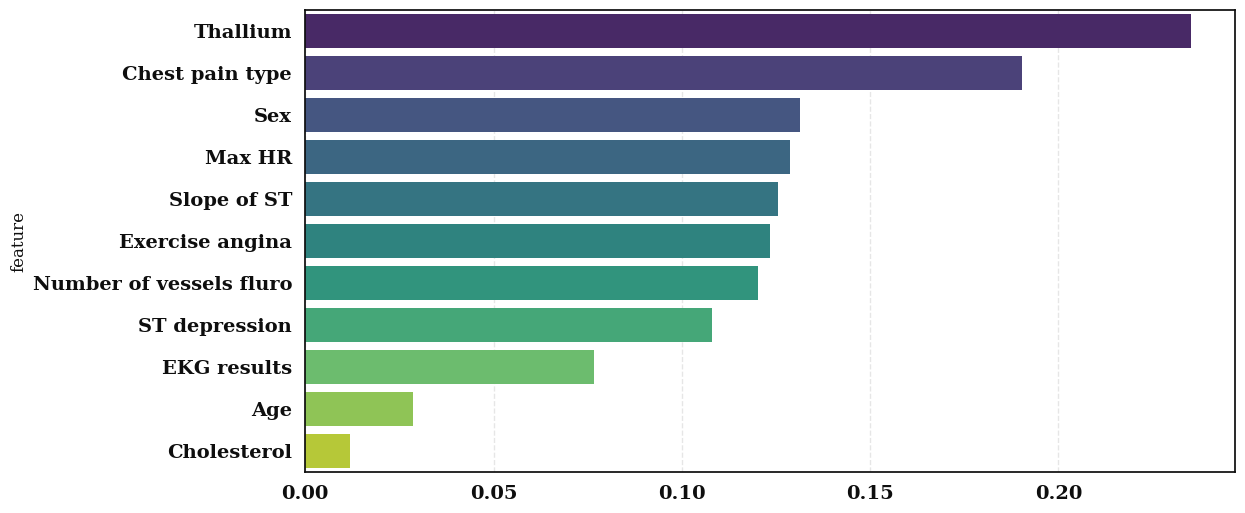

In [19]:
mic = mutual_info_classif(X, y)

mi = pd.DataFrame(
    {"feature": X.columns, 
     "Mutual Information": mic}
).set_index("feature")["Mutual Information"].sort_values(ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=mi.values, 
    y=mi.index,
    orient="h",
    palette="viridis",
    edgecolor="none",
    linewidth=0
)

plt.show()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Model">
    ✨ Model
  </h1>
</div>

In [20]:
model = tf.keras.Sequential([
    layers.Input(shape=(len(selected_cols),)),
    
    layers.Dense(8, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(4, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    weight_decay=0.0001,
)

2026-02-17 18:25:23.832479: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
console = Console()

class Processor:
    def __init__(self, X, y, test, models):
        self.oof_train = pd.DataFrame()
        self.oof_test = pd.DataFrame()
        self.val_scores = pd.DataFrame()
        
        self.X = X
        self.y = y
        self.test = test
        self.models = models

        self.cv = StratifiedKFold(
            n_splits=CFG.splits, 
            shuffle=CFG.shuffle, 
            random_state=CFG.seed
        )
        
    def process(self):
        for name, model in self.models:
            console.print(f"\n[bold blue]Model:[/bold blue] [cyan]{name}[/cyan]")
            self.cross_val_score(name, model)
            console.print(f"[bold green]Finished {name}[/bold green]\n" + "—" * 40)
    
    def cross_val_score(self, name, model):
        oof_tr = np.zeros(self.X.shape[0])
        oof_tt = np.zeros(self.test.shape[0])
        scores = []
        
        
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(self.X, self.y)):
            X_tr, y_tr = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]
            
            if name == "Tensorflow":
                sc = RobustScaler()
                X_tr = sc.fit_transform(X_tr)
                X_val = sc.transform(X_val)
                X_tt_fold = sc.transform(self.test)
                
                model = clone_model(model)
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
                model.fit(
                    X_tr, y_tr,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=32,
                    verbose=0
                )
                probs_val = model.predict(X_val, verbose=0).flatten()
                probs_test = model.predict(X_tt_fold, verbose=0).flatten()
            else:
                model.fit(X_tr, y_tr)
                probs_val = model.predict_proba(X_val)[:, 1]
                probs_test = model.predict_proba(self.test)[:, 1]
            
                
            oof_tr[val_idx] = probs_val
            oof_tt += probs_test / CFG.splits
            
            fold_score = roc_auc_score(y_val, probs_val)
            scores.append(fold_score)
            console.print(f"[dim]Fold {fold+1}: {fold_score:.4f}[/dim]")
            
        self.oof_train[name] = oof_tr
        self.oof_test[name] = oof_tt
        self.val_scores[name] = scores
        
        console.print(f"[bold orange]>>> {name} AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}[/bold orange]\n")

In [22]:
models = [
    (
        "Tensorflow", 
        model,
    ),
    ('hgb', Pipeline([
        ('model', HistGradientBoostingClassifier(
            **{'random_state':CFG.seed, 
               'max_iter': 615, 
               'max_depth': 15, 
               'learning_rate': 0.0849421325741134, 
               'l2_regularization': 0.26610703720676765, 
               'min_samples_leaf': 9, 
               'max_bins': 191}))
        ])
    ),
    (
        "LGBM",
        Pipeline([
            ("model", LGBMClassifier(
                objective="binary",
                metric="auc",
                verbosity=-1,
                random_state=CFG.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "XGBoost",
        Pipeline([
            ("model", XGBClassifier(
                objective="binary:logistic",
                eval_metric="auc",
                verbosity=0,
                random_state=CFG.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "CatBoost",
        Pipeline([
            ("model", CatBoostClassifier(
                objective="Logloss",
                eval_metric="AUC",
                verbose=0,
                random_state=CFG.seed,
            ))
        ])
    ),
    (
        "Logistic",
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(
                random_state=CFG.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "LDA",
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", LinearDiscriminantAnalysis())
        ])
    ),
]

In [23]:
stack = Processor(X, y, test, models)
stack.process()

Model: Tensorflow

Fold 1: 0.9512

Fold 2: 0.9528

Fold 3: 0.9520

Fold 4: 0.9508

Fold 5: 0.9528

Fold 6: 0.9535

Fold 7: 0.9527

Fold 8: 0.9523

Fold 9: 0.9519

Fold 10: 0.9535

>>> Tensorflow AUC: 0.95235 ± 0.00085

Finished Tensorflow
————————————————————————————————————————

Model: hgb

Fold 1: 0.9540

Fold 2: 0.9555

Fold 3: 0.9547

Fold 4: 0.9535

Fold 5: 0.9554

Fold 6: 0.9560

Fold 7: 0.9556

Fold 8: 0.9550

Fold 9: 0.9548

Fold 10: 0.9561

>>> hgb AUC: 0.95506 ± 0.00080

Finished hgb
————————————————————————————————————————

Model: LGBM

Fold 1: 0.9538

Fold 2: 0.9552

Fold 3: 0.9545

Fold 4: 0.9532

Fold 5: 0.9551

Fold 6: 0.9558

Fold 7: 0.9552

Fold 8: 0.9547

Fold 9: 0.9546

Fold 10: 0.9558

>>> LGBM AUC: 0.95476 ± 0.00078

Finished LGBM
————————————————————————————————————————

Model: XGBoost

Fold 1: 0.9538

Fold 2: 0.9550

Fold 3: 0.9543

Fold 4: 0.9534

Fold 5: 0.9550

Fold 6: 0.9557

Fold 7: 0.9553

Fold 8: 0.9547

Fold 9: 0.9546

Fold 10: 0.9557

>>> XGBoost AUC: 0.95475 ± 0.00073

Finished XGBoost
————————————————————————————————————————

Model: CatBoost

Fold 1: 0.9540

Fold 2: 0.9555

Fold 3: 0.9548

Fold 4: 0.9536

Fold 5: 0.9554

Fold 6: 0.9560

Fold 7: 0.9557

Fold 8: 0.9549

Fold 9: 0.9549

Fold 10: 0.9563

>>> CatBoost AUC: 0.95511 ± 0.00079

Finished CatBoost
————————————————————————————————————————

Model: Logistic

Fold 1: 0.9493

Fold 2: 0.9511

Fold 3: 0.9501

Fold 4: 0.9490

Fold 5: 0.9508

Fold 6: 0.9513

Fold 7: 0.9509

Fold 8: 0.9503

Fold 9: 0.9503

Fold 10: 0.9519

>>> Logistic AUC: 0.95049 ± 0.00085

Finished Logistic
————————————————————————————————————————

Model: LDA

Fold 1: 0.9477

Fold 2: 0.9495

Fold 3: 0.9487

Fold 4: 0.9478

Fold 5: 0.9494

Fold 6: 0.9499

Fold 7: 0.9491

Fold 8: 0.9484

Fold 9: 0.9489

Fold 10: 0.9504

>>> LDA AUC: 0.94898 ± 0.00084

Finished LDA
————————————————————————————————————————

In [24]:
oof_train = stack.oof_train.copy()
oof_test = stack.oof_test.copy()

X, y = oof_train, train["Heart Disease"]
test = oof_test

meta_estimators = [
    ('Ridge_LR', LogisticRegression(penalty='l2', C=1.0, random_state=CFG.seed)),
    ('Lasso_LR', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=CFG.seed)),
    ('ElasticNet_LR', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5, random_state=CFG.seed)),
    ('Calibrated_Ridge', CalibratedClassifierCV(RidgeClassifier(random_state=CFG.seed), cv=5)),
    ('Bayesian_Proba', GaussianNB())
]

In [25]:
final_layer = Processor(X, y, oof_test, meta_estimators)
final_layer.process()

Model: Ridge_LR

Fold 1: 0.9539

Fold 2: 0.9555

Fold 3: 0.9546

Fold 4: 0.9535

Fold 5: 0.9552

Fold 6: 0.9558

Fold 7: 0.9555

Fold 8: 0.9549

Fold 9: 0.9547

Fold 10: 0.9561

>>> Ridge_LR AUC: 0.95497 ± 0.00079

Finished Ridge_LR
————————————————————————————————————————

Model: Lasso_LR

Fold 1: 0.9539

Fold 2: 0.9555

Fold 3: 0.9546

Fold 4: 0.9535

Fold 5: 0.9553

Fold 6: 0.9559

Fold 7: 0.9555

Fold 8: 0.9549

Fold 9: 0.9548

Fold 10: 0.9562

>>> Lasso_LR AUC: 0.95501 ± 0.00079

Finished Lasso_LR
————————————————————————————————————————

Model: ElasticNet_LR

Fold 1: 0.9539

Fold 2: 0.9555

Fold 3: 0.9546

Fold 4: 0.9535

Fold 5: 0.9553

Fold 6: 0.9558

Fold 7: 0.9555

Fold 8: 0.9549

Fold 9: 0.9547

Fold 10: 0.9561

>>> ElasticNet_LR AUC: 0.95498 ± 0.00080

Finished ElasticNet_LR
————————————————————————————————————————

Model: Calibrated_Ridge

Fold 1: 0.9542

Fold 2: 0.9557

Fold 3: 0.9549

Fold 4: 0.9538

Fold 5: 0.9556

Fold 6: 0.9562

Fold 7: 0.9558

Fold 8: 0.9551

Fold 9: 0.9550

Fold 10: 0.9564

>>> Calibrated_Ridge AUC: 0.95527 ± 0.00078

Finished Calibrated_Ridge
————————————————————————————————————————

Model: Bayesian_Proba

Fold 1: 0.9497

Fold 2: 0.9515

Fold 3: 0.9506

Fold 4: 0.9496

Fold 5: 0.9511

Fold 6: 0.9519

Fold 7: 0.9515

Fold 8: 0.9508

Fold 9: 0.9510

Fold 10: 0.9522

>>> Bayesian_Proba AUC: 0.95100 ± 0.00080

Finished Bayesian_Proba
————————————————————————————————————————

In [26]:
# Checkout: https://github.com/Matt-OP/hillclimbers
# and https://www.kaggle.com/competitions/playground-series-s3e14/writeups/matt-op-4th-place-solution-introducing-hillclimber

test_preds_ensemble, oof_preds_ensemble = climb_hill(
    train=train,
    oof_pred_df=final_layer.oof_train,
    test_pred_df=final_layer.oof_test,
    target="Heart Disease",
    objective="maximize",
    eval_metric=partial(roc_auc_score),
    negative_weights=False,
    precision=0.001,
    plot_hill=False,
    return_oof_preds=True
)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (5 total): 

Calibrated_Ridge: 0.95526 (best solo model)
Lasso_LR:         0.95500
ElasticNet_LR:    0.95497
Ridge_LR:         0.95497
Bayesian_Proba:   0.95099

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: Bayesian_Proba | Best weight: 0.001 | Best roc_auc_score: 0.95526


In [27]:
oof_ranks_mean = stack.oof_train.rank(pct=True).mean(axis=1).copy()
test_ranks_mean = stack.oof_test.rank(pct=True).mean(axis=1).copy()

oof_ranks_final_mean = final_layer.oof_train.rank(pct=True).mean(axis=1).copy()
test_ranks_final_mean = final_layer.oof_test.rank(pct=True).mean(axis=1).copy()

true = train["Heart Disease"]

In [28]:
preds = [
    ("Rank + Mean | first layer", oof_ranks_mean),
    ("Rank + Mean | second layer", oof_ranks_final_mean),
    ("NR + HC | second layer", oof_preds_ensemble),
    ("RD + HC | second layer", rankdata(oof_preds_ensemble) / len(oof_preds_ensemble)),
]

for name, pred in preds:
    print(f"{name}: {roc_auc_score(true, pred):.6f}")

Rank + Mean | first layer: 0.954524
Rank + Mean | second layer: 0.955091
NR + HC | second layer: 0.955264
RD + HC | second layer: 0.955264


In [29]:
final_preds = [
    ("Rank + Mean | first layer", test_ranks_mean),
    ("Rank + Mean | second layer", test_ranks_final_mean),
    ("NR + HC | second layer", test_preds_ensemble),
    ("RD + HC | second layer", rankdata(test_preds_ensemble) / len(test_preds_ensemble)),
]

for name, pred in final_preds:
    sub["Heart Disease"] = pred
    sub.to_csv(f'{name}.csv', index=False)